# Air Quality Index of Santa Barbara County during the 2017 Thomas Fire

Author: Rosemary Juarez

Link to github repo: https://github.com/rosemaryjuarez/eds-220-hw4-task3

## Purpose

In December of 2017, The Thomas fire burned throughout Santa Barbara and Ventura county, creating distress and destructing in its wake. My interest in collecting the air quality during this time can shed light on the correlation between wildfires and air quality. I want to investigate how the Thomas Fire impacted the AQI in Santa Barbara county using public data provided by US Environmental Protection Agency.

## Highlights:
- vizualize raster data
- Time series analysis
- geospatial analysis
- remote sensing analysis
- False Color Imagery



## Dataset Description

- ### Landsat 8 imagery:
For raster data, this originated from NASA's Earth Observatory. The landsat imagery has a  collection of bands (red, green, blue, near-infrared and shortwave infrared) from the Landsat Collection 2 Level-2 atmosperically corrected surface reflectance data, collected by the Landsat 8 satellite. 

- ### Thomas Fire Perimeter:
For our Vector data, the Thomas fire perimeter polygon came from the CA State Geoportal, which comes with multiple fire perimeters.

- ### Air Quality Index
The Air Quality Index (AQI) data from the US Environmental Protection Agency. This data provides AQI coverage period from 2017 - 2018. 

### References to datasets
Landsat 8 imagery:
https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2

Thomas Fire Perimeter:
https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-fire-perimeters-all-1/about

AQI:
https://aqs.epa.gov/aqsweb/airdata/download_files.html#AQI


# Importing Data

We will first focus on importing all necessary data required for running this report. We must first import all important packages required to read and run the datasets.

In [15]:
# importing all neccessary packages
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# for raster
import rioxarray as rioxr

#for geometry in geopandas
from shapely.geometry import Polygon
from shapely.geometry import Point
from shapely.geometry import box

#now going to read in my data

#url for aqi_2017
#url_17 = 'https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2017.zip'
aqi_17 = pd.read_csv('data/aqi_17_18/daily_aqi_by_county_2017.csv')

#url for aqi_18
#url_18 = 'https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2018.zip'
aqi_18 = pd.read_csv('data/aqi_17_18/daily_aqi_by_county_2018.csv')

#reading in the landsat data
path = os.path.join(os.getcwd(),'data','landsat_8','landsat8-2018-01-26-sb-simplified.nc')
landsat = rioxr.open_rasterio(path)

# checking to make sure that everything looks good
landsat

#reading in the california fire perimeter for this
ca = gpd.read_file('data/ca_fire_perimeter/California_Fire_Perimeters_2017.shp')

# Geographical context of data
Since We are primarily exploring Santa Barbara county, our focus should be in this region. In the case of our landsat imagery, we are given a wide 30m x 30m pixel dimension of our area, giving us a relatively good spatial resolution for the area we are interested. As for the fire perimeter, we will need to filter our data to only include the Thomas fire. This will show us only the fire perimeter of Thomas fire, which includes SB and Ventura county. Our AQI data is not spatial, therefore we do not need to explain further geographical context except that we will filter to only include santa barbara county.

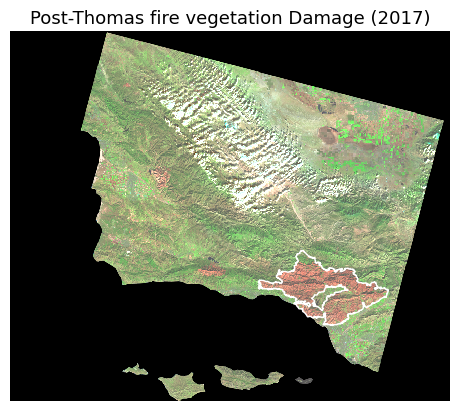

In [16]:
#first need to wrangle data
# and here i am just squeezing and dropping unneccesary data information, such as the band coordinates
landsat = landsat.squeeze()
landsat = landsat.drop('band')

#filtering for thomas fire only
thomas = ca[ca.FIRE_NAME == 'THOMAS']

#changing the crs to landsat so that it aligns well
thomas = thomas.to_crs(landsat.rio.crs)

# Customizing my map now to highlight thomas fire and the vegetation
fig, ax = plt.subplots()

landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust = True)
thomas.plot(ax = ax,
           edgecolor = 'white',
           facecolor = 'none')
ax.set_title('Post-Thomas fire vegetation Damage (2017)',  fontsize=13)
ax.axis('off')
plt.show()

# Data Exploration

Now that we established our geographic area of interest, we now shift towards looking at the Air Quality Index or AQI of Santa Barbara County. For this, we require more data exploration on our end, as this requires filtering and merging datasets in order to accomplish a time series as our final output

In [7]:
aqi_17.groupby('county Name').mean('AQI')

# (c) checking data type 
aqi_17.dtypes

# concatanating two dataframes together
aqi = pd.concat([aqi_17, aqi_18])

# initial column names: notice caps and spaces (difficult to work with!)

# re-assign the column names - .str.lower() makes them lower case
aqi.columns = aqi.columns.str.lower()

#  re-assign the column names again - .str.replace(' ','_') replaces the space for _
aqi.columns = aqi.columns.str.replace(' ','_')

# selecting data from SB county using conditionals
aqi_sb = aqi[aqi.county_name == 'Santa Barbara']


#removing columns using.drop()
aqi_sb = aqi_sb.drop(columns = ['state_name', 'county_name', 'state_code', 'county_code'])

#changing to datetime for date
aqi_sb['date'] = pd.to_datetime(aqi_sb.date)


# checking if index is updated
aqi_sb.index
# it is not, so i will reset it
aqi_sb.reset_index(inplace = True, drop = True)

# adding the new column by updating it
aqi_sb['five_day_average'] = aqi_sb.aqi.rolling(window = 5).mean()


We now want to plot our time series graph on Santa Barbara county's AQI during 2017-2018.

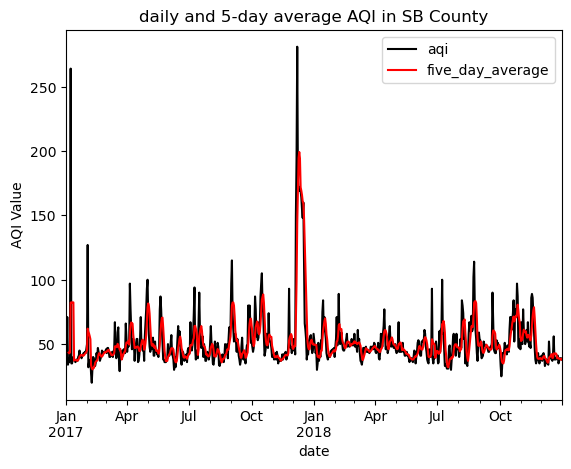

In [8]:
#PLOTTING TIME

#creating colors first for the lines
colors = {'aqi': 'Black',
         'five_day_average': 'red'}

#line plot of the AQI using the new column i just added
aqi_sb.plot(kind = 'line',
           x = 'date',
           y = ['aqi', 'five_day_average'],
           color = colors,
           title ='daily and 5-day average AQI in SB County',
           ylabel = 'AQI Value')
plt.show()

# analysis

We find that during the end of December of 2017, the AQI peaked approximately past the value of 250. According to the EPA, a value higher than 200 is considered 'very unhealthy', and could pose health risks to those exposed. Given that we see that there were high AQI values during the Thomas Fire, we can assume that there is correlation between the two. WE clearly see an impact from the fires affecting the AQI.

Our false color imagery depicting the Thomas Fire scars reveals the extent of recent damage done to the vegetation during post-wilfire. Since the vegetation scars coincide with the fire perimeter of Thomas fires, we can also conclude that the fire caused those scars. Overall, the impact Thomas Fire caused to AQI is clear, and we can visually represent it.

# Final Output

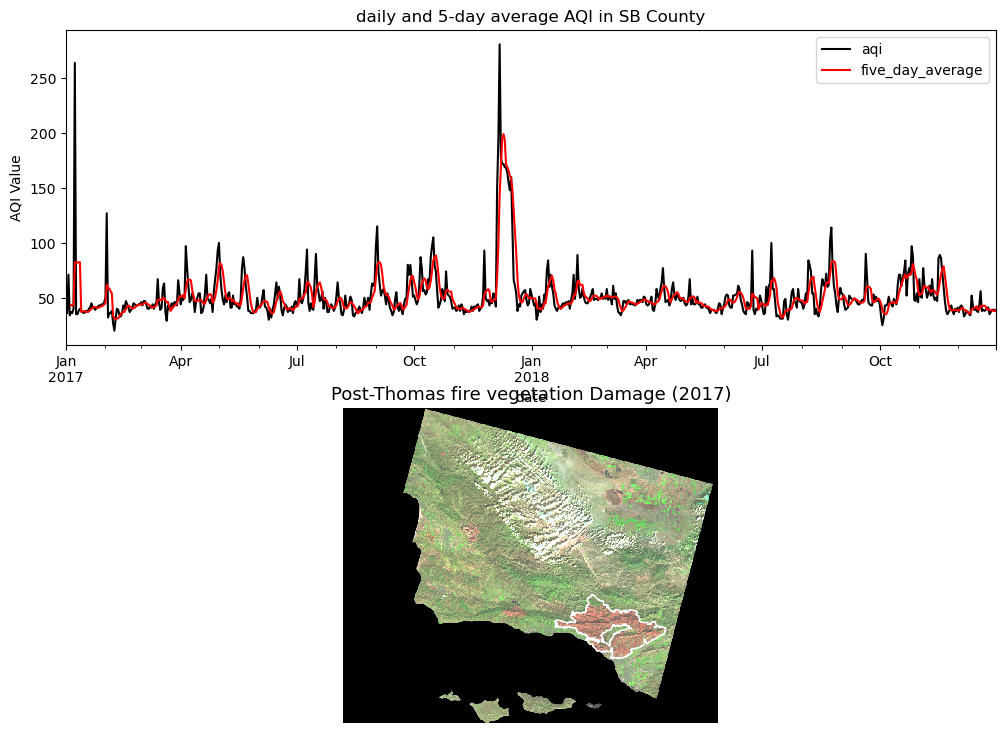

In [17]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,9))

# AQI plot
aqi_sb.plot(ax = ax1,
            kind = 'line',
           x = 'date',
           y = ['aqi', 'five_day_average'],
           color = colors,
           title ='daily and 5-day average AQI in SB County',
           ylabel = 'AQI Value')
#------------------------------------------------------------------------
# False Color Imagery
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust = True)
thomas.plot(ax = ax2,
           edgecolor = 'white',
           facecolor = 'none')
ax2.set_title('Post-Thomas fire vegetation Damage (2017)',  fontsize=13)
ax2.axis('off')
plt.show()
